# CNN guitar test
## 自作データセットの学習用
## 20231103_CNN_audio_testの結果を元に自作データセットの学習を行う

In [1]:
import os
import time as ti
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

from sklearn import model_selection
from sklearn import preprocessing

import librosa
import librosa.display

import IPython.display as ipd

In [2]:
base_dir = "C:/Users/shuhei/anaconda3/envs/hololens/workspace/"
dataset_dir = os.path.join(base_dir, "dataset/")
asses_dir_list = ["good/", "normal/", "bad/"]

In [16]:
def load_wave_data(audio_dir, file_name):
    file_path = os.path.join(audio_dir, file_name)
    x, fs = librosa.load(file_path)
    return x, fs

def calculate_melsp(x, n_fft=1024, hop_length=128):
    stft = np.abs(librosa.stft(x, n_fft=n_fft, hop_length=hop_length))**2
    log_sftf = librosa.power_to_db(stft)
    melsp = librosa.feature.melspectrogram(S=log_sftf, n_mels=128)
    return melsp

def show_wave(x):
    plt.plot(x)
    plt.show()

def show_melsp(melsp, fs):
    librosa.display.specshow(melsp, sr=fs, y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()

good/092.wav
wave size:(66150,)
melsp size:(128, 517)
sampling rate:22050


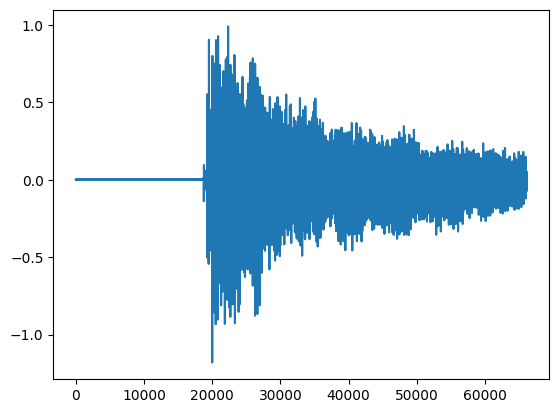

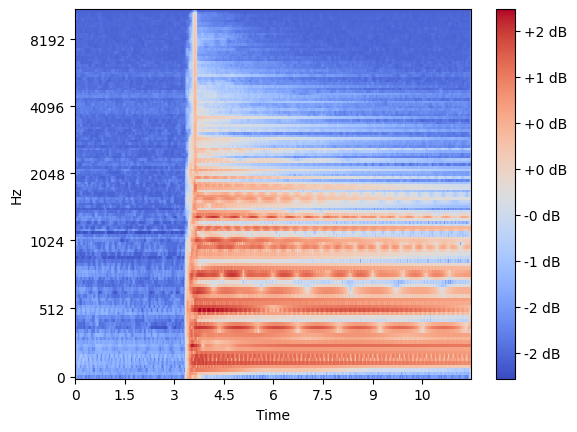

In [35]:
file_num = str(92).zfill(3) + ".wav"
file_name = os.path.join(asses_dir_list[0], file_num)
print(file_name)
x, fs = load_wave_data(dataset_dir, file_name)
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [13]:
ipd.Audio(x, rate=fs)

In [14]:
def add_white_noise(x, rate=0.002):
    return x + rate*np.random.randn(len(x))

wave size:(66150,)
melsp size:(128, 517)
samping rate:22050


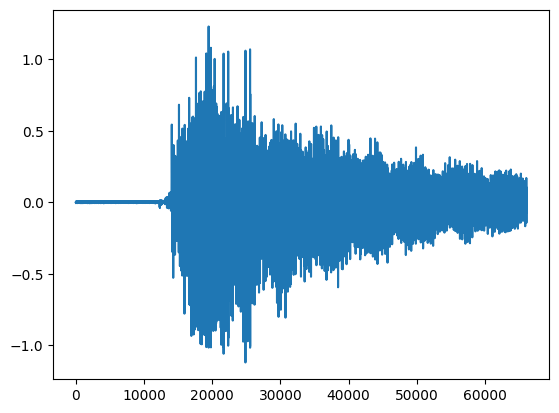

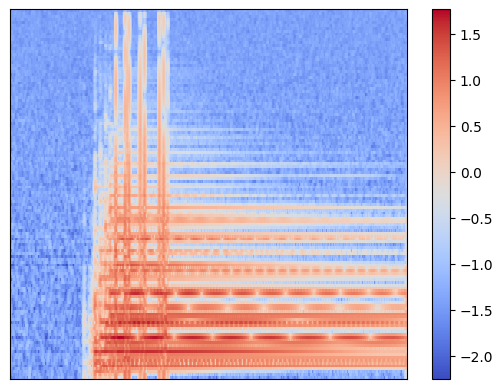

In [15]:
x_w = add_white_noise(x)
melsp = calculate_melsp(x_w)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_w.shape, melsp.shape, fs))
show_wave(x_w)
show_melsp(melsp, fs)

In [16]:
ipd.Audio(x_w, rate=fs)

In [29]:
def shift_sound(x, rate=2):
    return np.roll(x, int(len(x)//rate))

wave size:(66150,)
melsp size:(128, 517)
samping rate:22050


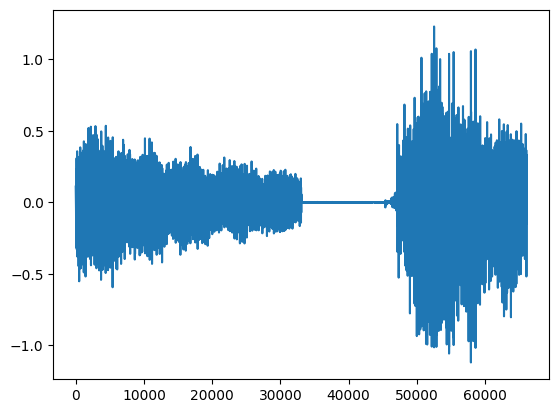

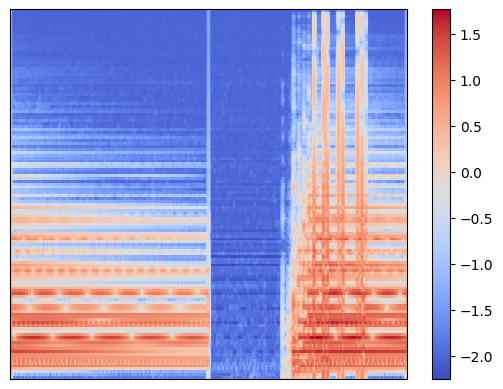

In [30]:
x_ss = shift_sound(x)
melsp = calculate_melsp(x_ss)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_ss.shape, melsp.shape, fs))
show_wave(x_ss)
show_melsp(melsp, fs)

In [19]:
ipd.Audio(x_ss, rate=fs)

In [20]:
def stretch_sound(x, rate=1.1):
    input_length = len(x)
    x = librosa.effects.time_stretch(y=x, rate=rate)
    if len(x) > input_length:
        return x[:input_length]
    else:
        return np.pad(x, (0, max(0, input_length - len(x))), "constant")

wave size:(66150,)
melsp size:(128, 517)
samping rate:22050


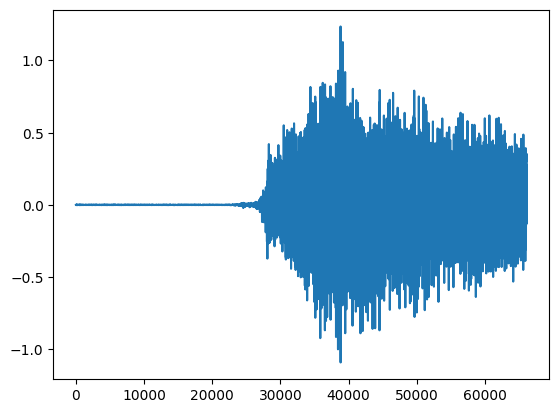

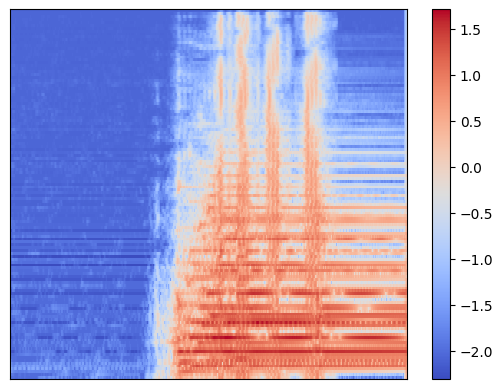

In [21]:
x_st = stretch_sound(x, rate=0.5)
melsp = calculate_melsp(x_st)
print("wave size:{0}\nmelsp size:{1}\nsamping rate:{2}".format(x_st.shape, melsp.shape, fs))
show_wave(x_st)
show_melsp(melsp, fs)

In [22]:
ipd.Audio(x_st, rate=fs)

In [68]:
x = []
y = []
for i in range(0, 3):
    for n in range(0, 100):
        file_num = str(n).zfill(3) + ".wav"
        filename = os.path.join(asses_dir_list[i], file_num)
        x.append(filename)
        y.append(i)

In [69]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.2, stratify=y)
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(len(x_train),
                                                                len(y_train), 
                                                                len(x_test), 
                                                                len(y_test)))

x train:240
y train:240
x test:60
y test:60


In [70]:
a = np.zeros(3, dtype=np.int16)
for c in y_test:
    a[c] += 1
print(a)

[20 20 20]


In [71]:
freq = 128
time = 517

In [72]:
def save_np_data(filename, x, y, aug=None, rates=None):
    np_data = np.zeros(freq*time*len(x)).reshape(len(x), freq, time)
    np_targets = np.zeros(len(y))
    for i in range(len(y)):
        _x, fs = load_wave_data(dataset_dir, x[i])
        if aug is not None:
            _x = aug(x=_x, rate=rates[i])
        _x = calculate_melsp(_x)
        np_data[i] = _x
        np_targets[i] = y[i]
    np.savez(filename, x=np_data, y=np_targets)

In [73]:
guitar_dataset_dir = os.path.join("./../", "dataset/")

In [74]:
path = os.path.join(guitar_dataset_dir, "gar_melsp_test.npz")
if not os.path.exists(path):
    save_np_data(path, x_test, y_test)

In [75]:
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_raw.npz")
if not os.path.exists(path):
    save_np_data(path, x_train,  y_train)

In [53]:
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_wn.npz")
if not os.path.exists(path):
    rates = np.random.randint(1,50,len(x_train))/10000
    save_np_data(path, x_train,  y_train, aug=add_white_noise, rates=rates)

In [54]:
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_ss.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(2,6),len(y_train))
    save_np_data(path, x_train,  y_train, aug=shift_sound, rates=rates)

In [55]:
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_st.npz")
if not os.path.exists(path):
    rates = np.random.choice(np.arange(80,120),len(y_train))/100
    save_np_data(path, x_train,  y_train, aug=stretch_sound, rates=rates)

In [58]:
path = os.path.join(guitar_dataset_dir, "gar_melsp_train_com.npz")
if not os.path.exists(path):
    np_data = np.zeros(freq*time*len(x_train)).reshape(len(x_train), freq, time)
    np_targets = np.zeros(len(y_train))
    for i in range(len(y_train)):
        x, fs = load_wave_data(dataset_dir, x_train[i])
        x = add_white_noise(x=x, rate=np.random.randint(1,50)/1000)
        if np.random.choice((True,False)):
            x = shift_sound(x=x, rate=np.random.choice(np.arange(2,6)))
        else:
            x = stretch_sound(x=x, rate=np.random.choice(np.arange(80,120))/100)
        x = calculate_melsp(x)
        np_data[i] = x
        np_targets[i] = y_train[i]
    np.savez(path, x=np_data, y=np_targets)

In [59]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Conv2D, GlobalAveragePooling2D
from keras.layers import BatchNormalization, Add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

In [83]:
_train_files = ["gar_melsp_train_raw.npz", 
               "gar_melsp_train_ss.npz",
               "gar_melsp_train_st.npz", 
               "gar_melsp_train_wn.npz",
               "gar_melsp_train_com.npz"]
_test_file = "gar_melsp_test.npz"

In [84]:
train_files = [os.path.join(guitar_dataset_dir, path) for path in _train_files]
test_file = os.path.join(guitar_dataset_dir, _test_file)

In [85]:
train_num = 240
test_num = 60

In [86]:
x_train = np.zeros(freq*time*train_num*len(train_files)).reshape(train_num*len(train_files), freq, time)
y_train = np.zeros(train_num*len(train_files))

In [87]:
for i in range(len(train_files)):
    data = np.load(train_files[i])
    x_train[i*train_num:(i+1)*train_num] = data["x"]
    y_train[i*train_num:(i+1)*train_num] = data["y"]

In [88]:
test_data = np.load(test_file)
x_test = test_data["x"]
y_test = test_data["y"]

In [89]:
classes = 3
y_train = keras.utils.to_categorical(y_train, classes)
y_test = keras.utils.to_categorical(y_test, classes)

In [90]:
x_train = x_train.reshape(train_num*5, freq, time, 1)
x_test = x_test.reshape(test_num, freq, time, 1)

In [92]:
print("x train:{0}\ny train:{1}\nx test:{2}\ny test:{3}".format(x_train.shape,
                                                                y_train.shape, 
                                                                x_test.shape, 
                                                                y_test.shape))

x train:(1200, 128, 517, 1)
y train:(1200, 3)
x test:(60, 128, 517, 1)
y test:(60, 3)


In [93]:
y_test.shape

(60, 3)

In [94]:
def cba(inputs, filters, kernel_size, strides):
    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [95]:
inputs = Input(shape=(x_train.shape[1:]))

x_1 = cba(inputs, filters=32, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=32, kernel_size=(8,1), strides=(2,1))
x_1 = cba(x_1, filters=64, kernel_size=(1,8), strides=(1,2))
x_1 = cba(x_1, filters=64, kernel_size=(8,1), strides=(2,1))

x_2 = cba(inputs, filters=32, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=32, kernel_size=(16,1), strides=(2,1))
x_2 = cba(x_2, filters=64, kernel_size=(1,16), strides=(1,2))
x_2 = cba(x_2, filters=64, kernel_size=(16,1), strides=(2,1))

x_3 = cba(inputs, filters=32, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=32, kernel_size=(32,1), strides=(2,1))
x_3 = cba(x_3, filters=64, kernel_size=(1,32), strides=(1,2))
x_3 = cba(x_3, filters=64, kernel_size=(32,1), strides=(2,1))

x_4 = cba(inputs, filters=32, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=32, kernel_size=(64,1), strides=(2,1))
x_4 = cba(x_4, filters=64, kernel_size=(1,64), strides=(1,2))
x_4 = cba(x_4, filters=64, kernel_size=(64,1), strides=(2,1))

x = Add()([x_1, x_2, x_3, x_4])

x = cba(x, filters=128, kernel_size=(1,16), strides=(1,2))
x = cba(x, filters=128, kernel_size=(16,1), strides=(2,1))

x = GlobalAveragePooling2D()(x)
x = Dense(classes)(x)
x = Activation("softmax")(x)

model = Model(inputs, x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 517, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 259, 32  288         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_4 (Conv2D)              (None, 128, 259, 32  544         ['input_1[0][0]']                
                                )                                                             

In [96]:
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.001, decay=1e-6, amsgrad=True)

In [97]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [99]:
model_dir = "./../models"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

In [100]:
es_cb = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
chkpt = os.path.join(model_dir, 'guitar_.{epoch:02d}_{val_loss:.4f}_{accuracy:.4f}.hdf5')
cp_cb = ModelCheckpoint(filepath = chkpt, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [101]:
class MixupGenerator():
    def __init__(self, x_train, y_train, batch_size=16, alpha=0.2, shuffle=True):
        self.x_train = x_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(x_train)

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                x, y = self.__data_generation(batch_ids)

                yield x, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.x_train.shape
        _, class_num = self.y_train.shape
        x1 = self.x_train[batch_ids[:self.batch_size]]
        x2 = self.x_train[batch_ids[self.batch_size:]]
        y1 = self.y_train[batch_ids[:self.batch_size]]
        y2 = self.y_train[batch_ids[self.batch_size:]]
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        x_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        x = x1 * x_l + x2 * (1 - x_l)
        y = y1 * y_l + y2 * (1 - y_l)

        return x, y

In [102]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11639624228421690173
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3643801600
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 11595178120512286159
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [103]:
batch_size = 16
epochs = 10

start_time = ti.time()
with tensorflow.device('/GPU:0'):
    
    training_generator = MixupGenerator(x_train, y_train)()
    model.fit_generator(generator=training_generator,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=(x_test, y_test),
                        epochs=epochs, 
                        verbose=1,
                        shuffle=True,
                        callbacks=[es_cb, cp_cb])

    """
    model.fit(x_train, y_train,
              steps_per_epoch=x_train.shape[0] // batch_size,
              validation_data=(x_test, y_test),
              epochs=epochs, 
              verbose=1,
              shuffle=True,
              callbacks=[es_cb, cp_cb])
    """
    
end_time = ti.time()
print("time:", end_time - start_time)

Epoch 1/10


C:\Users\shuhei\AppData\Local\Temp\ipykernel_23076\1680937680.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=training_generator,


75/75 [==============================] - ETA: 0s - loss: 0.6188 - accuracy: 0.7875
Epoch 1: val_loss improved from inf to 0.66316, saving model to ./../models\guitar_.01_0.6632_0.7875.hdf5
75/75 [==============================] - 40s 374ms/step - loss: 0.6188 - accuracy: 0.7875 - val_loss: 0.6632 - val_accuracy: 0.8167
Epoch 2/10
75/75 [==============================] - ETA: 0s - loss: 0.4006 - accuracy: 0.9117
Epoch 2: val_loss improved from 0.66316 to 0.42063, saving model to ./../models\guitar_.02_0.4206_0.9117.hdf5
75/75 [==============================] - 27s 353ms/step - loss: 0.4006 - accuracy: 0.9117 - val_loss: 0.4206 - val_accuracy: 0.9000
Epoch 3/10
75/75 [==============================] - ETA: 0s - loss: 0.3737 - accuracy: 0.9308
Epoch 3: val_loss did not improve from 0.42063
75/75 [==============================] - 33s 436ms/step - loss: 0.3737 - accuracy: 0.9308 - val_loss: 0.5325 - val_accuracy: 0.7667
Epoch 4/10
75/75 [==============================] - ETA: 0s - loss: 0.

In [104]:
model = load_model("./../models/guitar_.08_0.0511_0.9567.hdf5")

In [105]:
evaluation = model.evaluate(x_test, y_test)
print(evaluation)

2/2 [==============================] - 1s 297ms/step - loss: 0.0511 - accuracy: 1.0000
[0.051115114241838455, 1.0]


bad/050.wav
wave size:(66150,)
melsp size:(128, 517)
sampling rate:22050


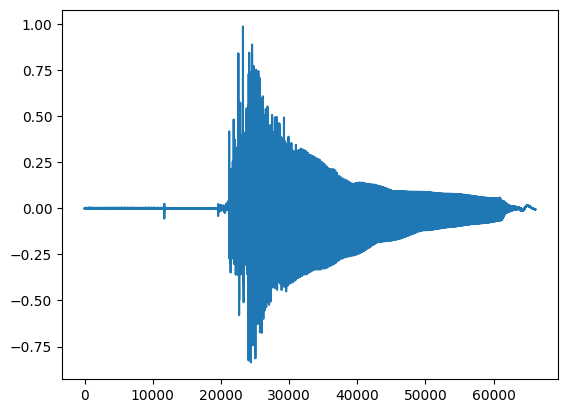

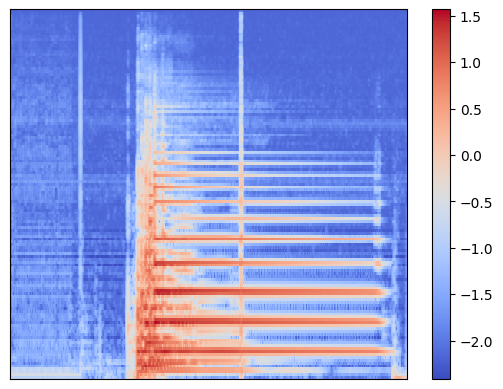

In [117]:
file_num = str(50).zfill(3) + ".wav"
file_name = os.path.join(asses_dir_list[2], file_num)
print(file_name)
x, fs = load_wave_data(dataset_dir, file_name)
melsp = calculate_melsp(x)
print("wave size:{0}\nmelsp size:{1}\nsampling rate:{2}".format(x.shape, melsp.shape, fs))
show_wave(x)
show_melsp(melsp, fs)

In [118]:
ipd.Audio(x, rate=fs)

In [119]:
pred = model.predict(melsp.reshape(1, 128, 517, 1))

1/1 [==============================] - 0s 18ms/step


In [120]:
pred_label = np.argmax(pred)

In [121]:
pred_label

2

In [125]:
x.shape

(66150,)